In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
#from helpers import read_metrics_csvs, read_fastas
import math
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib as mpl
from IPython import display
from collections import OrderedDict

import urllib.request

from pathlib import Path

import math


In [16]:
MAIN_TEXT_METRICS = ["CARP-640m", "ESM-1v", "ESM-MSA", "BLOSUM62", "Identity", "Rosetta-relax", "ESM-IF", "ProteinMPNN", "MIF-ST", "AlphaFold2 pLDDT"]
ALL_METRICS = ["net_charge", "abs_net_charge", "Charged fraction", "CARP-640m", "ESM-1v", "ESM-1v mask6", "ESM-MSA", "phmmer_top_30_avg_score", "BLOSUM62", "PFASUM15", "Identity", "Rosetta-relax", "ESM-IF", "ProteinMPNN", "MIF-ST", "sasa", "polar_sasa", "apolar_sasa", "percent_polar_sasa", "AlphaFold2 pLDDT"] #, "longest_repeat_1", "longest_repeat_2"]

MODEL_HUE_ORDER = ["test", "ASR", "GAN", "ESM-MSA"]
ACTIVITY_STYLE_ORDER = [0,1]
ROUND_HUE_ORDER = ["round1","round2"]
SET_HUE_ORDER = ["passing","control"]

heatmap_cmap="Blues"

# "9467bd" # purple
# "17becf" # teal

set_colors_map=OrderedDict([
    ("passing","#17becf"),
    ("selected","#17becf"),
    ("control","#9467bd"),
    ("round 2","black")
])


In [5]:
metrics_path = Path("../data/experimentally_tested_metrics.csv")

if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/records/10594384/files/experimentally_tested_metrics.csv", metrics_path)

quant_data_path = Path("../data/Experimental_results_tabulation.xlsx")
if not quant_data_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/records/10594384/files/Experimental_results_tabulation.xlsx", quant_data_path)
experimentally_tested_metrics = pd.read_csv(metrics_path)
outdir = "figs"

# main text figures

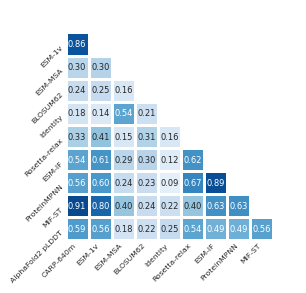

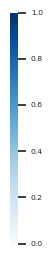

In [16]:
# Average spearman

_ = sns.set(font_scale=0.5)
_ = sns.set_style('white')

MDH_df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Family'] == "MDH")
]

CuSOD_df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Family'] == "CuSOD")
]

MDH_spearman = MDH_df[MAIN_TEXT_METRICS].corr("spearman")
CuSOD_spearman = CuSOD_df[MAIN_TEXT_METRICS].corr("spearman")

average_spearman = (MDH_spearman + CuSOD_spearman) / 2

fig, ax = plt.subplots(figsize=(3, 3))
mask = np.triu(average_spearman)
fig2, ax2 = plt.subplots(figsize=(0.1, 3))
_ = sns.heatmap(average_spearman, annot=True, fmt='.2f', linewidths=1, linecolor="white", cmap=heatmap_cmap,
            vmin=0, vmax=1, ax=ax, mask=mask, square=True, cbar_ax=ax2)
ax.set_xticks(ax.get_xticks()[:-1], ax.get_xticklabels()[:-1], rotation=45, ha='right')
ax.set_yticks(ax.get_yticks()[1:], ax.get_yticklabels()[1:], rotation=45, va='top')
ax.tick_params(pad=-5)
fig.savefig(f"{outdir}/round2_main_text_metrics_average_spearman.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{outdir}/round2_main_text_metrics_average_spearman_cbar.png", dpi=300, bbox_inches='tight')


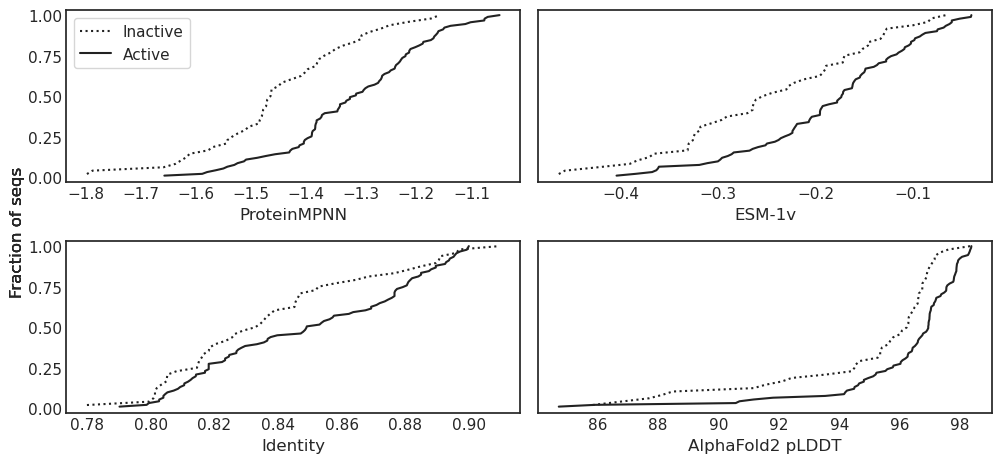

In [17]:
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

_ = sns.set(font_scale=1.0)
_ = sns.set_style('white')
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(10, 4.8))
for idx, (metric, family) in enumerate((("ProteinMPNN", ""), ("ESM-1v", ""), ("Identity", ""), ("AlphaFold2 pLDDT", ""))):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] != "pre-test")
        ]
    df = df.groupby('Activity')[metric].apply(ecdf, False).reset_index(level=0).reset_index(drop=True)
    ax = axs.ravel()[idx]
    for a, (m, la) in enumerate(zip([':', '-'], ['Inactive', 'Active'])):
        _ = ax.plot(df[df['Activity'] == a]['x'], df[df['Activity'] == a]['y'], m, label=la, color='#222222')
    if idx == 0:
        _ = ax.legend()
    ax.set_ylim([-0.03, 1.03])
    ax.tick_params(left=False, bottom=False, pad=-3)
    # ax.set(yticklabels=[], xticklabels=[])
    fig.text(0.0, 0.5, 'Fraction of seqs', va='center', rotation='vertical')

    # if idx % 2 == 0:
    #     ax.set_ylabel('Fraction of seqs')
    ax.set_xlabel(metric)
fig.tight_layout()
fig.savefig(f"{outdir}/round2_ecdfs.png", dpi=300, bbox_inches='tight')

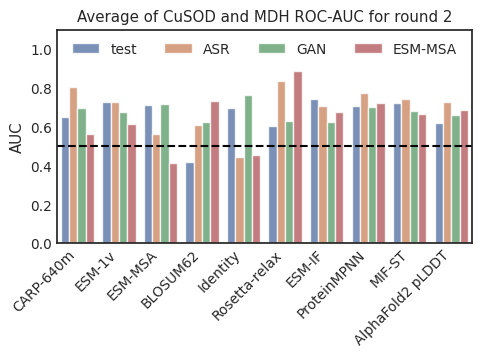

In [18]:
roc_dfs = dict()
families = ("MDH", "CuSOD")
for family in families:
    fpr_by_model = dict()
    tpr_by_model = dict()
    roc_auc_by_model = dict()
    for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
        metric_i = 0
        df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'].isin(model)) &
        (experimentally_tested_metrics['Family'] == family)
        ]

        if model == ("test", "ASR", "GAN", "ESM-MSA"):
            model = "all"
        elif model == ("ASR", "GAN", "ESM-MSA"):
            model = "generated"
        else:
            model = model[0]
        roc_auc_by_model[model] = dict()

        for metric in ALL_METRICS:
            fpr_by_model[(model, metric)], tpr_by_model[(model, metric)], _ = roc_curve( df['Activity'], df[metric])
            roc_auc_by_model[model][metric] = auc(fpr_by_model[(model, metric)], tpr_by_model[(model, metric)])
    roc_dfs[family] = pd.DataFrame(roc_auc_by_model)

roc_dfs["average"] = (roc_dfs["MDH"] + roc_dfs["CuSOD"]) / 2

_ = sns.set(font_scale=0.9)
_ = sns.set_style('white')

fig, ax = plt.subplots(figsize=(5,3.7))
#display.display(roc_df.melt(value_vars=["test","ASR","GAN","ESM-MSA"], ignore_index=False, var_name="model", value_name="AUC"))
roc_df_melted = roc_dfs["average"].melt(value_vars=["test","ASR","GAN","ESM-MSA"], ignore_index=False, var_name="Model", value_name="AUC").sort_values("AUC", ascending=False) # add ["all"] to value_vars
# display.display(roc_df_melted)
roc_df_melted["Family"] = family

#order = roc_df_melted[roc_df_melted["Model"] == "all"].index.copy()
plot = sns.barplot(data=roc_df_melted, x=roc_df_melted.index, y="AUC", hue="Model", ax=ax, hue_order=MODEL_HUE_ORDER, order=MAIN_TEXT_METRICS, alpha=0.8) # add ["all"] to value_vars
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
ax.axhline(0.5, color="black", linestyle="--")
ax.set_ylim(0, 1.1)
ax.tick_params(pad=-3)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(handles, labels, ncol=4, loc='upper center', 
               bbox_to_anchor=(0.5, 1), frameon=False)

# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
_ = ax.set_title('Average of CuSOD and MDH ROC-AUC for round 2')
fig.tight_layout()
fig.savefig(f"{outdir}/round2_AUCs_average_barplot.png", dpi=300)
#fig.show()


In [36]:
#combos = (("GAN","CuSOD"), ("ESM-MSA", "CuSOD"), ("GAN", "MDH"), ("ESM-MSA", "MDH")) 

fig, axes = plt.subplots(2,2,  figsize=(7,7))
esm1v_cutoffs = {'CuSOD': -0.111278511583805, 'MDH': -0.1379929780960083}
MPNN_cutoffs = {'GAN': {'CuSOD': -1.1572, 'MDH': -1.3644}, 'ESM-MSA': {'CuSOD': -1.0861, 'MDH': -1.2315}}
model_colors = {'GAN': "#2ca02c", 'ESM-MSA': '#d62728'}
model_category_colors = {'GAN-passing': "#2ca02c",'GAN-control': "#2ca02c", 'ESM-MSA-passing': '#d62728', 'ESM-MSA-control': '#d62728'}
for i, family in enumerate(("CuSOD", "MDH")):
    
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round3') &
        #((experimentally_tested_metrics['Model'].isin(["GAN-passing","ESM-MSA-passing]) | (experimentally_tested_metrics['Model'] == model +"-control")) & 
        (experimentally_tested_metrics['Family'] == family)
    ]
    df = df.copy()
    df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
    axes[0][i].axvline(esm1v_cutoffs[family], color="grey", linestyle="--")
    for model in ("GAN", "ESM-MSA"):
        axes[0][i].axhline(MPNN_cutoffs[model][family], color=model_colors[model], linestyle="--")
    ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, hue="Set", palette=set_colors_map, style="Activity", style_order=ACTIVITY_STYLE_ORDER, ax=axes[0][i])
    #ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, hue="Model", palette=model_category_colors, style="Activity", style_order=ACTIVITY_STYLE_ORDER, ax=axes[0][i])
    ax.set_title(f"{family}")
    ax.get_legend().remove()
    #plot += 1
    ax.set_ylim((-2, -0.8))
    # fig.show()
    
    #fig, ax = plt.subplots()
#    sns.stripplot(data=df, x="Activity", y="Identity", hue="Set", ax=axes[1], hue_order=SET_HUE_ORDER, order=[0,1], alpha=0.6)
    
    # sns.kdeplot(data=df[df["Activity"] == 0], x="Identity", linestyle="-", hue="Set", hue_order=SET_HUE_ORDER, ax=axes[2])#, common_norm=False)  #not active
    # sns.kdeplot(data=df[df["Activity"] == 1], x="Identity", linestyle="--", hue="Set", hue_order=SET_HUE_ORDER, ax=axes[2])#, common_norm=False) #active
    #print(df[df["Activity"] == 1])
#fig.tight_layout()
#fig.show()
#plt.savefig(f"{outdir}/round3_fig_{x}_{y}.png", dpi=300)

#fig, axes = plt.subplots(1,2,  figsize=(8,4))

df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3')
    #((experimentally_tested_metrics['Model'].isin(["GAN-passing","ESM-MSA-passing]) | (experimentally_tested_metrics['Model'] == model +"-control")) & 
#    (experimentally_tested_metrics['Family'] == family)
].copy()
df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
# sns.stripplot(data=df, x="Activity", y="Identity", hue="Set", ax=axes[1][0], hue_order=SET_HUE_ORDER, order=[0,1], alpha=0.6)
# axes[1][0].set_xticklabels(["No","Yes"])
#fig.show()

# sns.kdeplot(data=df[df["Activity"] == 0], x=metric, linestyle="-", hue="Set", hue_order=SET_HUE_ORDER, linewidth=1, ax=axes[1])#, common_norm=False)
# sns.kdeplot(data=df[df["Activity"] == 1], x=metric, linestyle="--", hue="Set", hue_order=SET_HUE_ORDER, linewidth=1, ax=axes[1])#, common_norm=False)

banded = {"Set":list(), "Identity Band": list(), "Percent Active":list(), "Count":list(), "Active":list()}
for band in ((0.68,0.72),(0.72,0.76),(0.76,0.80)):
    for set_ in ("passing","control"):
        sub_df = df[(df["Identity"] > band[0]) & (df["Identity"] <= band[1]) & (df["Set"] == set_)]
        active = sum(sub_df["Activity"])
        total = len(sub_df)
        banded["Set"].append(set_)
        banded["Identity Band"].append(str(band))
        banded["Percent Active"].append(100 * (active / total))
        banded["Count"].append(total)
        banded["Active"].append(active)
#pd.DataFrame(banded)
#print(sum(banded["Count"]))
sns.barplot(data=pd.DataFrame(banded), x="Identity Band", y="Percent Active",  hue="Set",  palette=set_colors_map, ax=axes[1][1], alpha=0.6)
axes[1][1].set_ylim(0,100)
axes[1][1].get_legend().remove()


fig.delaxes(axes[1][0])
fig.tight_layout()
fig.show()
fig.savefig(f"{outdir}/round3_summary_fig.svg", dpi=300)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))
plot = 0
for model, family in (("GAN","CuSOD"),):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round3') &
        ((experimentally_tested_metrics['Model'] == model +"-passing") | (experimentally_tested_metrics['Model'] == model +"-control")) & 
        (experimentally_tested_metrics['Family'] == family)
    ]
    df = df.copy()
    df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
    
    df.loc[212, "Set"]="passing"
    df.loc[390, "Set"]="round 2"
    ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, ax=axes[plot // 2, plot % 2], hue="Set", palette=set_colors_map, style="Activity", style_order=ACTIVITY_STYLE_ORDER)
    # if y == "ESM-1v":
    #     ax.axhline(esm1v_cutoffs[family], color="grey", linestyle="--")
    # if x == "ProteinMPNN":
    #     ax.axvline(MPNN_cutoffs[family], color="grey", linestyle="--")
    ax.set_title(f"{model}, {family}")
    legend=ax.legend()
    for text in legend.get_texts():
        if text.get_text() == "0":
            text.set_text("No")
        if text.get_text() == "1":
            text.set_text("Yes")
    plot += 1
    plt.tight_layout()
    fig.show()
    plt.savefig(f"{outdir}/round3_fig_legend.svg")
    print(pd.DataFrame(banded))

/tmp/ipykernel_737/3916450197.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_737/3916450197.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


       Set Identity Band  Percent Active  Count  Active
0  passing  (0.68, 0.72)       60.000000      5       3
1  control  (0.68, 0.72)        0.000000      4       0
2  passing  (0.72, 0.76)       60.000000     20      12
3  control  (0.72, 0.76)       31.818182     22       7
4  passing   (0.76, 0.8)       80.851064     47      38
5  control   (0.76, 0.8)       50.000000     46      23


/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#454545') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#454545') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


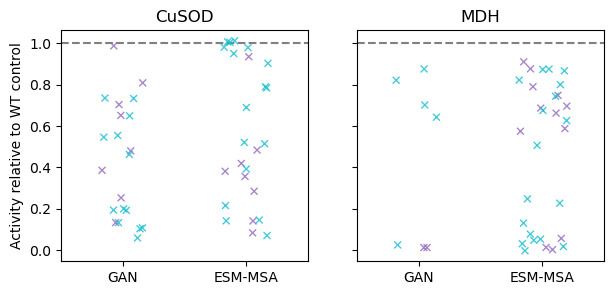

In [19]:
SOD_quant = pd.read_excel(quant_data_path, sheet_name="CuSOD_assay_data")
MDH_quant = pd.read_excel(quant_data_path, sheet_name="MDH_assay_data")

#clean and rearrange SOD data
CuSOD_round3 = SOD_quant[SOD_quant["Batch No."] == "Round 3"].copy()
CuSOD_round3["Model"] = CuSOD_round3["Group"].str.split("_").map(lambda x: x[0])
CuSOD_round3["Partition"] = CuSOD_round3["Group"].str.split("_").map(lambda x: x[1])
CuSOD_control_averages = dict()
for group in {"ESM-MSA_control", "ESM-MSA_selected", "GAN_control", "GAN_selected"}:
    subset = CuSOD_round3.loc[(CuSOD_round3["Group"] == group) & (CuSOD_round3["Sample"].isin({"E.SOD", "hSOD", "p.a.SOD"}))]
    CuSOD_control_averages[group] = subset["Average / µg"].mean()
CuSOD_round3["Activity relative to WT control"] = CuSOD_round3.apply(lambda x: x["Average / µg"] / CuSOD_control_averages[x["Group"]], axis=1)

#clean and rearrange MDH data
MDH_round3 = MDH_quant[MDH_quant["Batch No."] == "Round 3"].copy()
MDH_round3["Model"] = MDH_round3["Group"].str.split("_").map(lambda x: x[0])
MDH_round3["Partition"] = MDH_round3["Group"].str.split("_").map(lambda x: x[1])
MDH_control_averages = dict()
for group in {"ESM-MSA_control", "ESM-MSA_selected", "GAN_control", "GAN_selected"}:
    subset = MDH_round3.loc[(MDH_round3["Group"] == group) & (MDH_round3["Sample"].isin({"MDH4"}))]
    MDH_control_averages[group] = subset["Average / µg"].mean()
MDH_round3["Activity relative to WT control"] = MDH_round3.apply(lambda x: x["Average / µg"] / MDH_control_averages[x["Group"]], axis=1)


# figure with one row and two columns:
fig, ax = plt.subplots(figsize=(7, 3), nrows=1, ncols=2, sharey=True)


# marker should be "x"
sns.stripplot(data=CuSOD_round3[(CuSOD_round3["called active"] == "Y") & 
                                (CuSOD_round3["Model"].isin({"GAN", "ESM-MSA"}) )], hue="Partition", x="Model", 
                                y="Activity relative to WT control", jitter=0.2, palette=set_colors_map, 
                                order=["GAN", "ESM-MSA"], ax=ax[0], marker='x', linewidth=1, alpha=0.8)

# set title
ax[0].set_title("CuSOD")
# remove x-axis label
ax[0].set_xlabel("")
ax[0].get_legend().remove()
ax[0].axhline(1.0, color="grey", linestyle="--")


sns.stripplot(data=MDH_round3[(MDH_round3["called active"] == "Y" ) & 
                              (MDH_round3["Model"].isin({"GAN", "ESM-MSA"}) )], hue="Partition", x="Model",
                              y="Activity relative to WT control", jitter=0.2, palette=set_colors_map,
                              order=["GAN", "ESM-MSA"], ax=ax[1], marker='x', linewidth=1, alpha=0.8)
# set title
ax[1].set_title("MDH")
# remove x-axis label
ax[1].set_xlabel("")
# remove the legend
ax[1].get_legend().remove()
ax[1].set_ylabel("")
ax[1].axhline(1.0, color="grey", linestyle="--")


# move legend outside of plot
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("MDH_CuSOD_round3_activity.png", bbox_inches='tight', dpi=300)
plt.savefig(f"{outdir}/MDH_CuSOD_round3_activity.svg", bbox_inches='tight')

# Supplementary figures

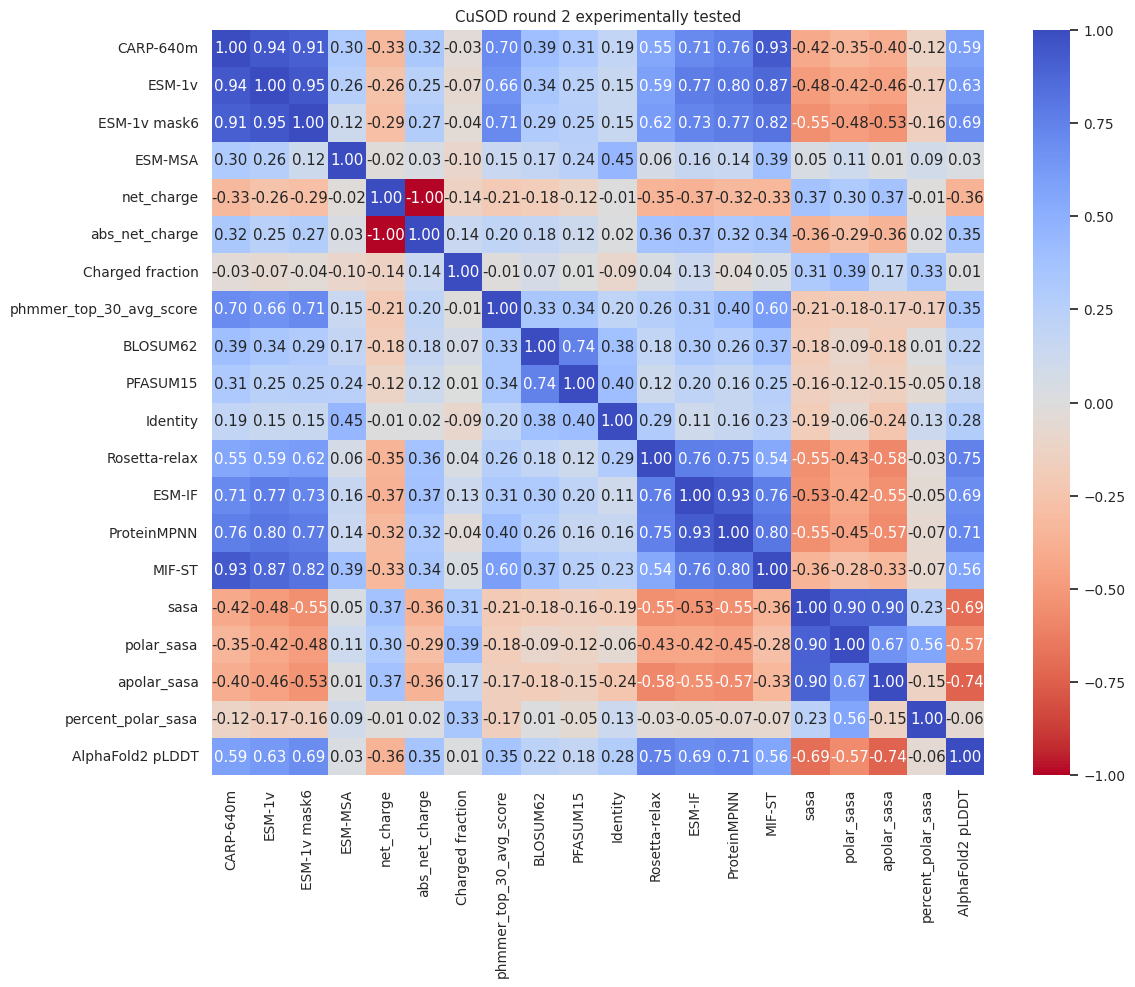

In [20]:
family = "CuSOD"
plt.figure(figsize = (12,10))
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) & 
    (experimentally_tested_metrics['Family'] == family)
]
sns.heatmap(df[ALL_METRICS].corr("spearman"), annot=True, fmt='.2f', cmap="coolwarm_r", vmin=-1, vmax=1)
plt.title(f"{family} round 2 experimentally tested")
plt.tight_layout()
#plt.show()
plt.savefig(f"{outdir}/round2_supplemental_metrics_{family}.png", dpi=300)


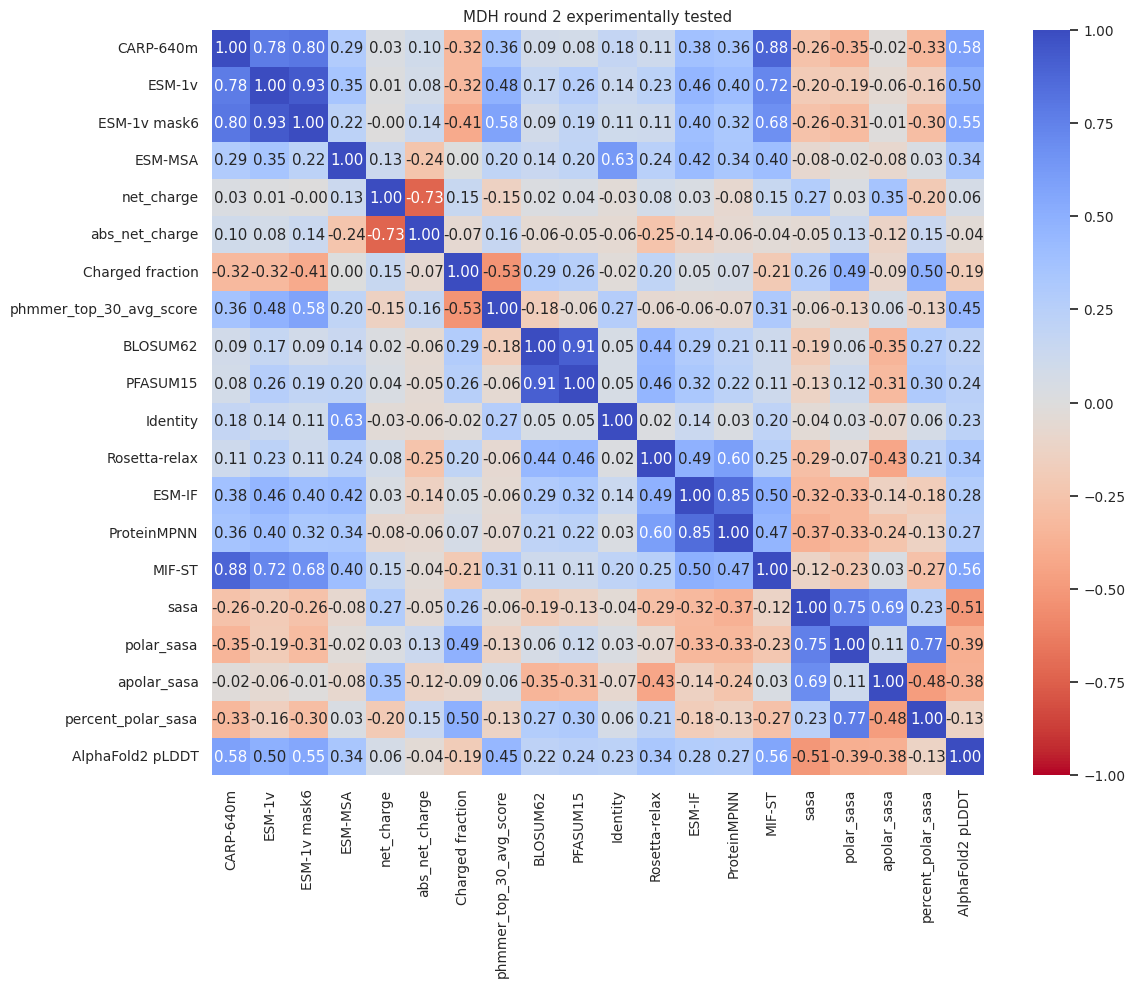

In [21]:
family = "MDH"
plt.figure(figsize = (12,10))
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) & 
    (experimentally_tested_metrics['Family'] == family)
]
sns.heatmap(df[ALL_METRICS].corr("spearman"), annot=True, fmt='.2f', cmap="coolwarm_r", vmin=-1, vmax=1)
plt.title(f"{family} round 2 experimentally tested")
plt.tight_layout()
#plt.show()
plt.savefig(f"{outdir}/round2_supplemental_metrics_{family}.png", dpi=300)

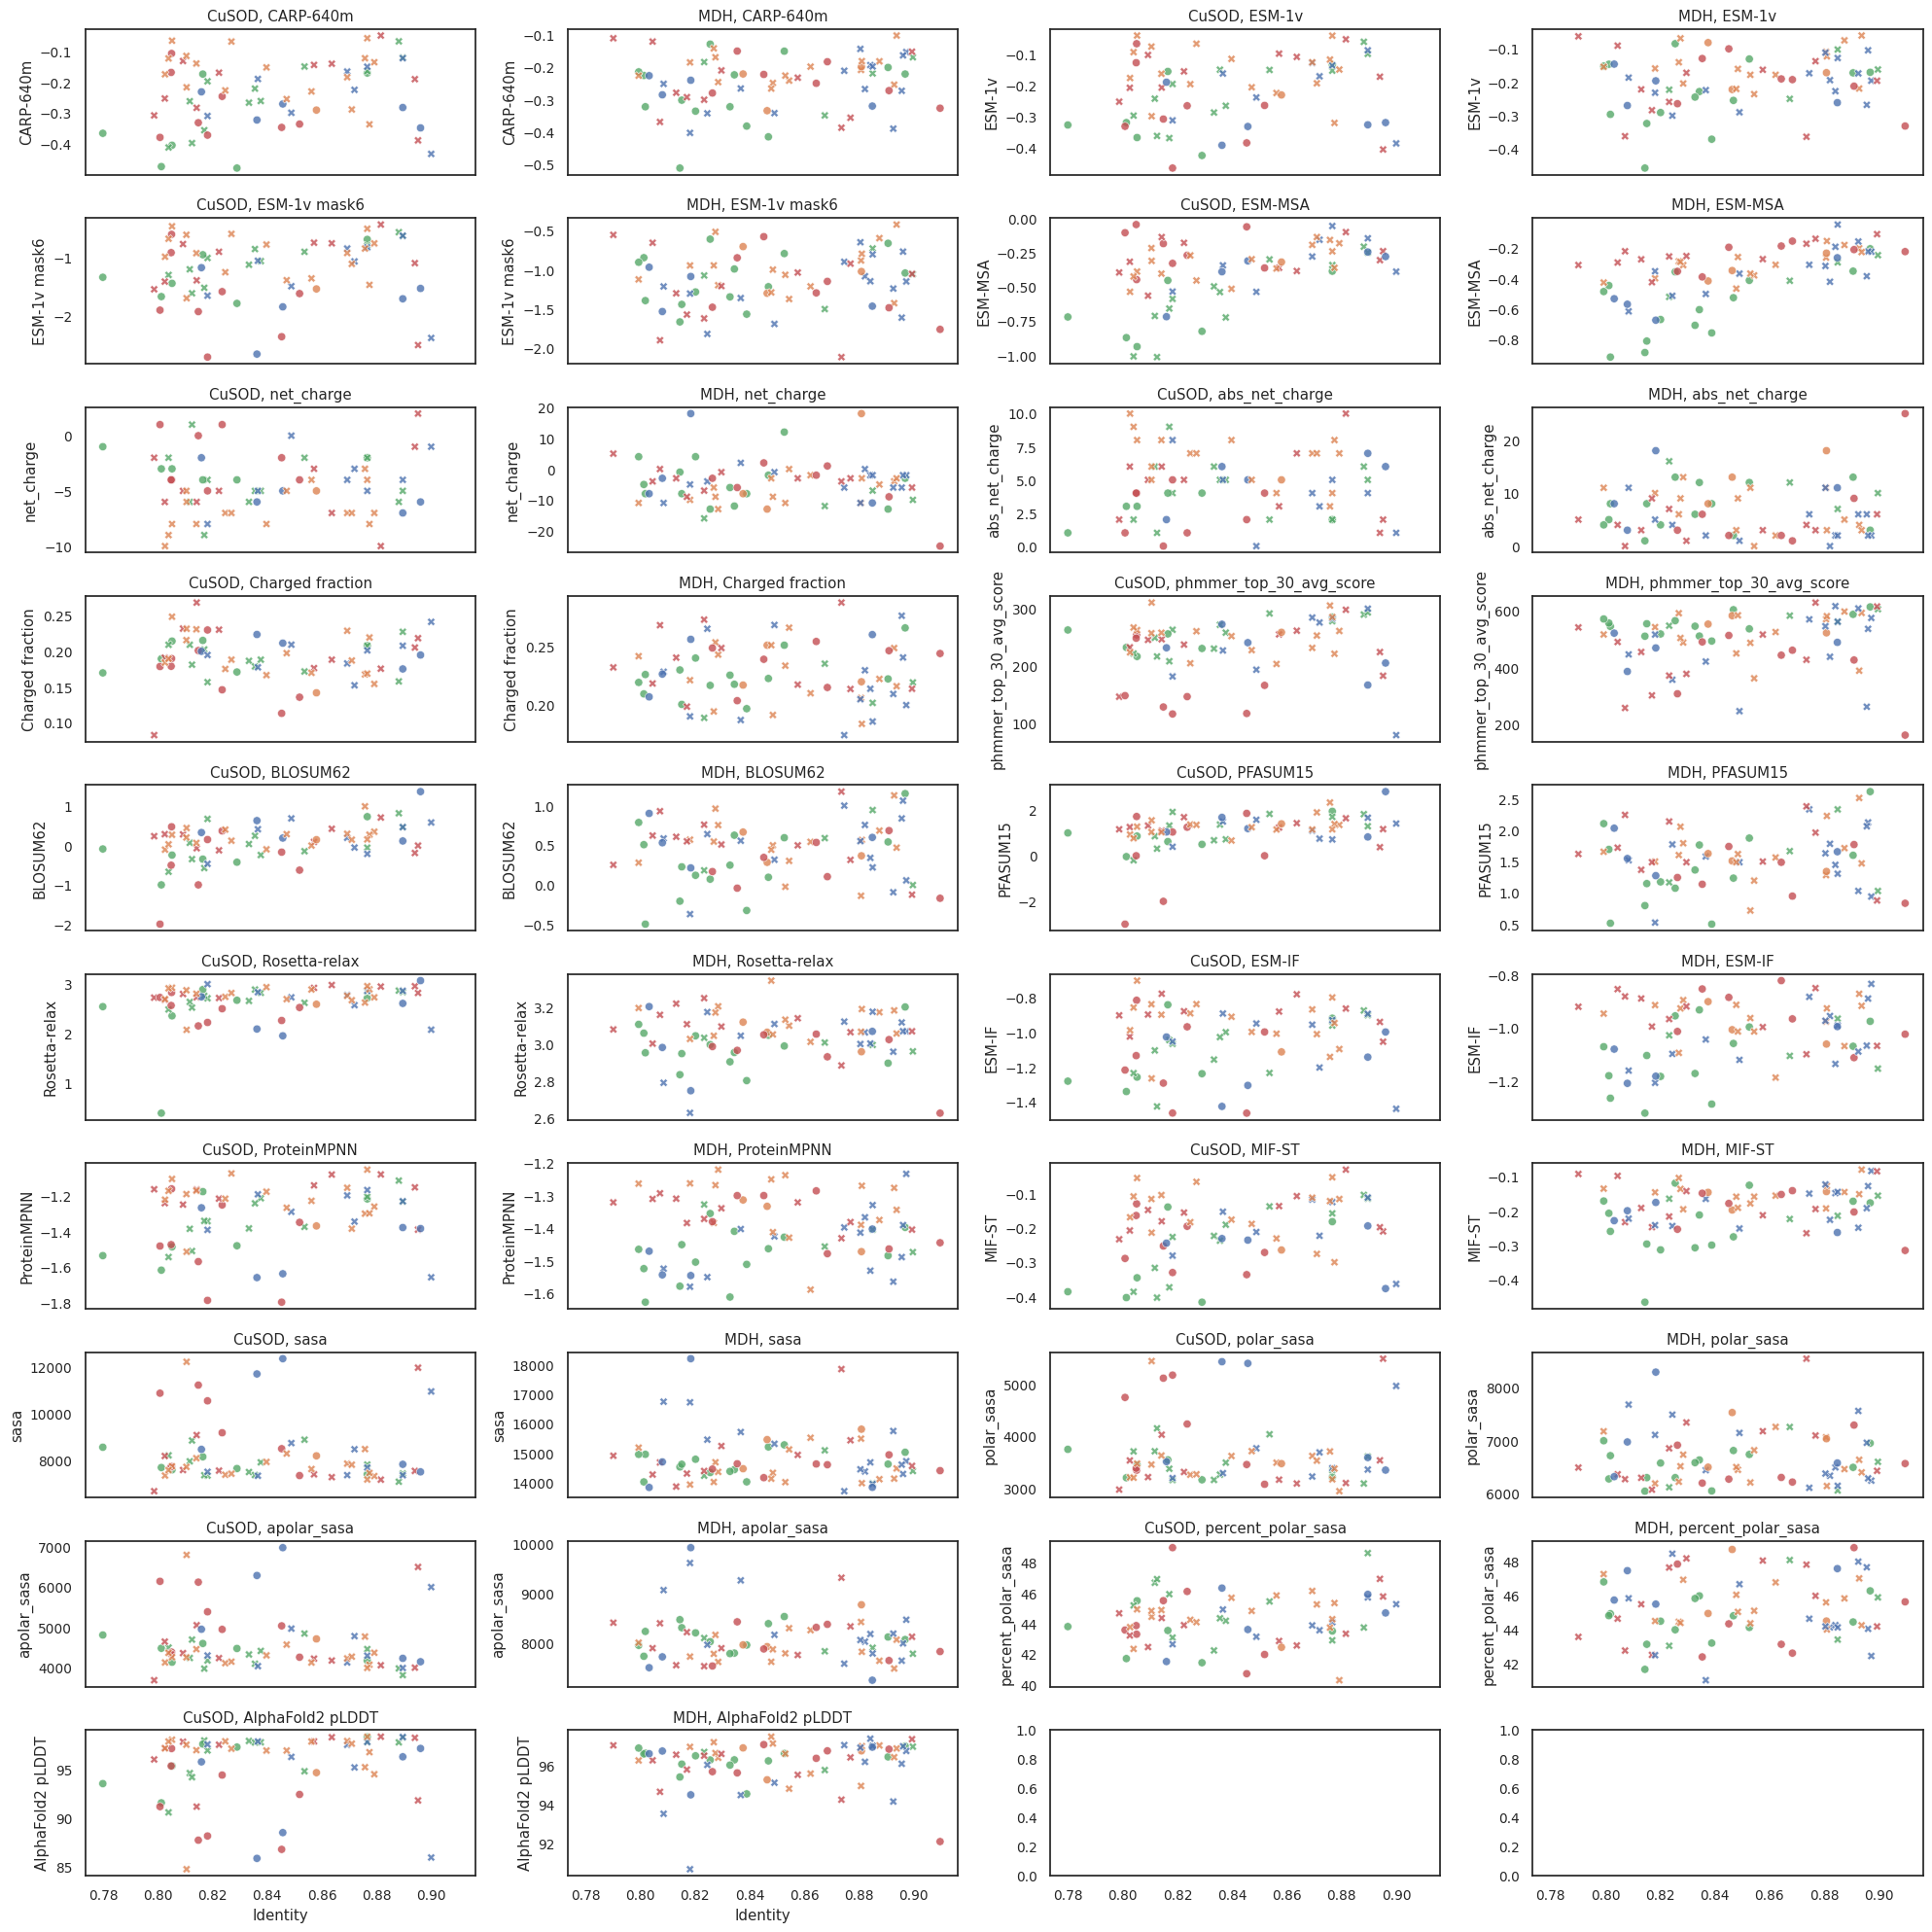

In [22]:
fig, axes = plt.subplots(math.ceil((len(ALL_METRICS) - 1)/2), 4, sharex=True, sharey=False, figsize=(20,20))
axes = axes.flat
ax_i = -1
for metric in ALL_METRICS:
    if metric == "Identity":
        continue

    for family_i, family in enumerate(["CuSOD", "MDH"]):
        df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] != "pre-test" ) & 
        (experimentally_tested_metrics['Family'] == family)
        ]
        ax_i += 1
        ax = sns.scatterplot(x="Identity", y=metric, data=df, alpha=0.8, ax=axes[ax_i], hue="Model", hue_order=MODEL_HUE_ORDER, style="Activity", style_order=ACTIVITY_STYLE_ORDER)
        ax.title.set_text(f"{family}, {metric}")
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_metrics_vs_identity_CuSOD_left_MDH_right.png", dpi=300)

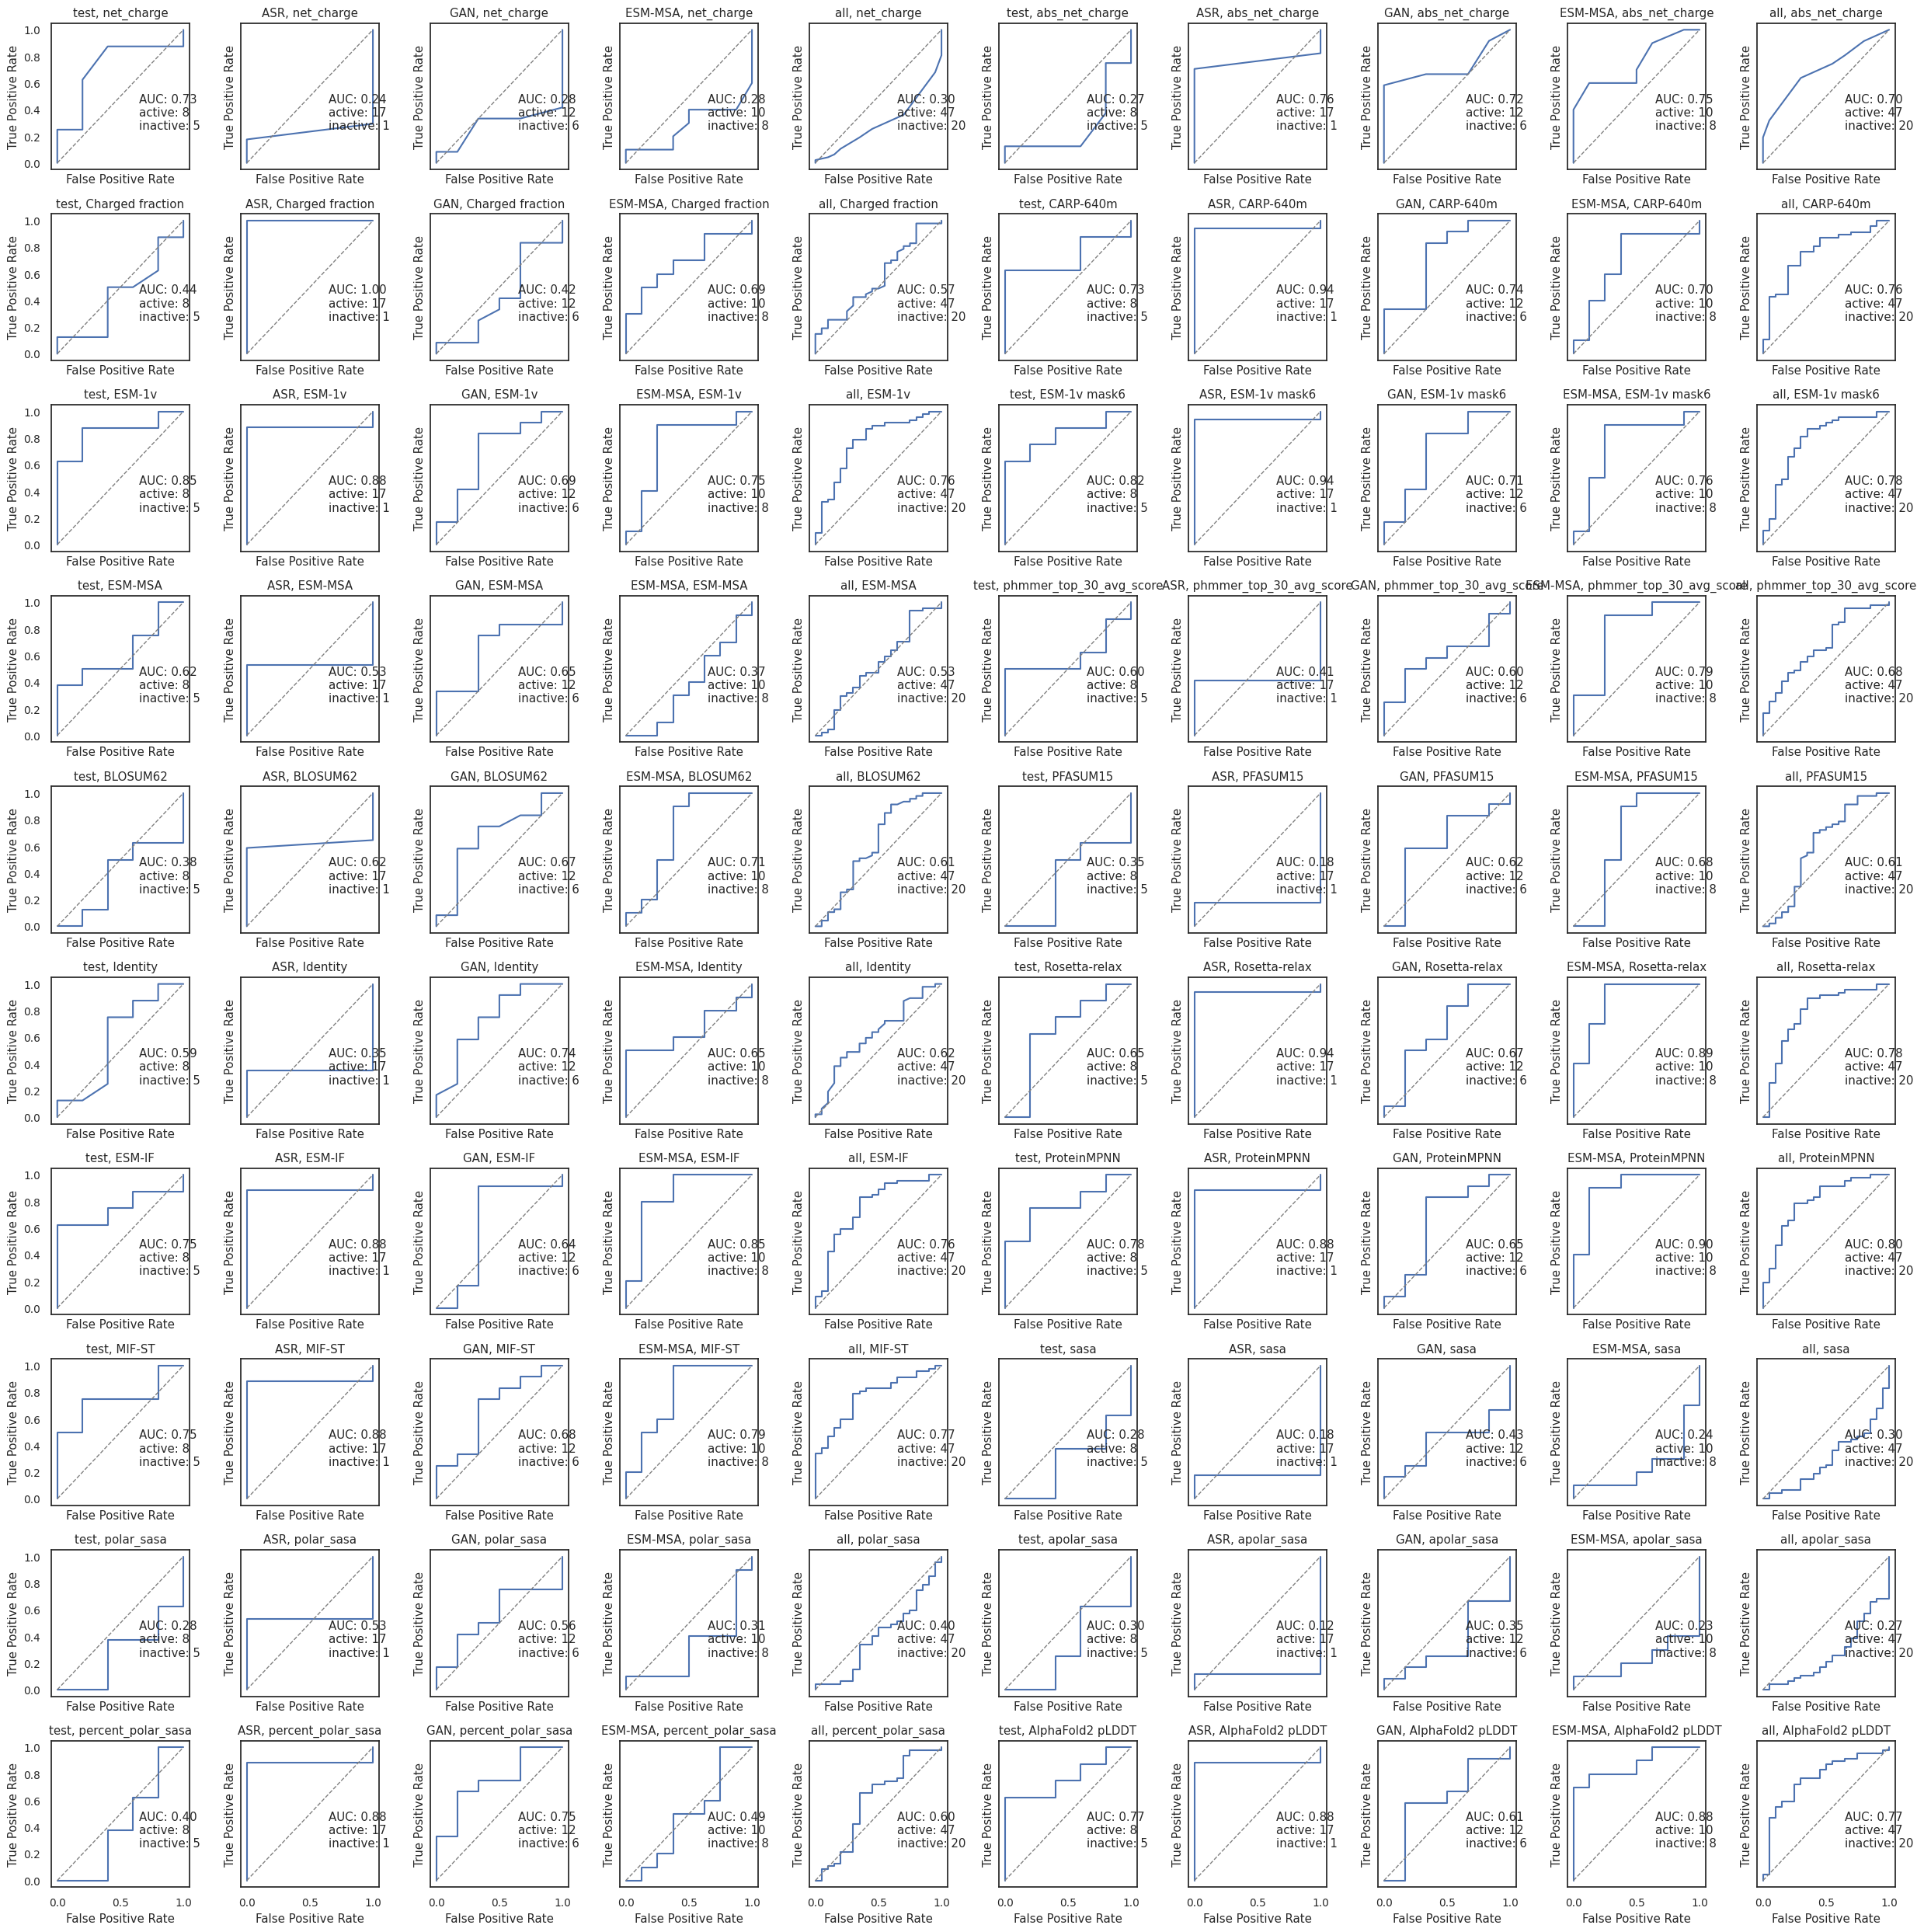

In [27]:
fig, axes = plt.subplots(math.ceil(5*(len(ALL_METRICS))/10), 10, sharex=True, sharey='row', figsize=(25,25))
axes = axes.flat
family = "CuSOD"
aucs_dict = dict() # dict of dicts to store AUCs
ax_i = -1
for metric in ALL_METRICS:

    for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
        
        df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'].isin(model)) & 
        (experimentally_tested_metrics['Family'] == family)
        ]
        
        if model == ("test", "ASR", "GAN", "ESM-MSA"):
            model = "all"
        else:
            model = model[0]
        
        if model not in aucs_dict:
            aucs_dict[model] = dict()    
    
        ax_i += 1
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[ax_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        aucs_dict[model][metric] = auc_value
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_AUCs_{family}.png", dpi=300)
pd.DataFrame(aucs_dict).to_csv(f"{outdir}/round2_supplemental_AUCs_{family}.tsv", sep="\t")

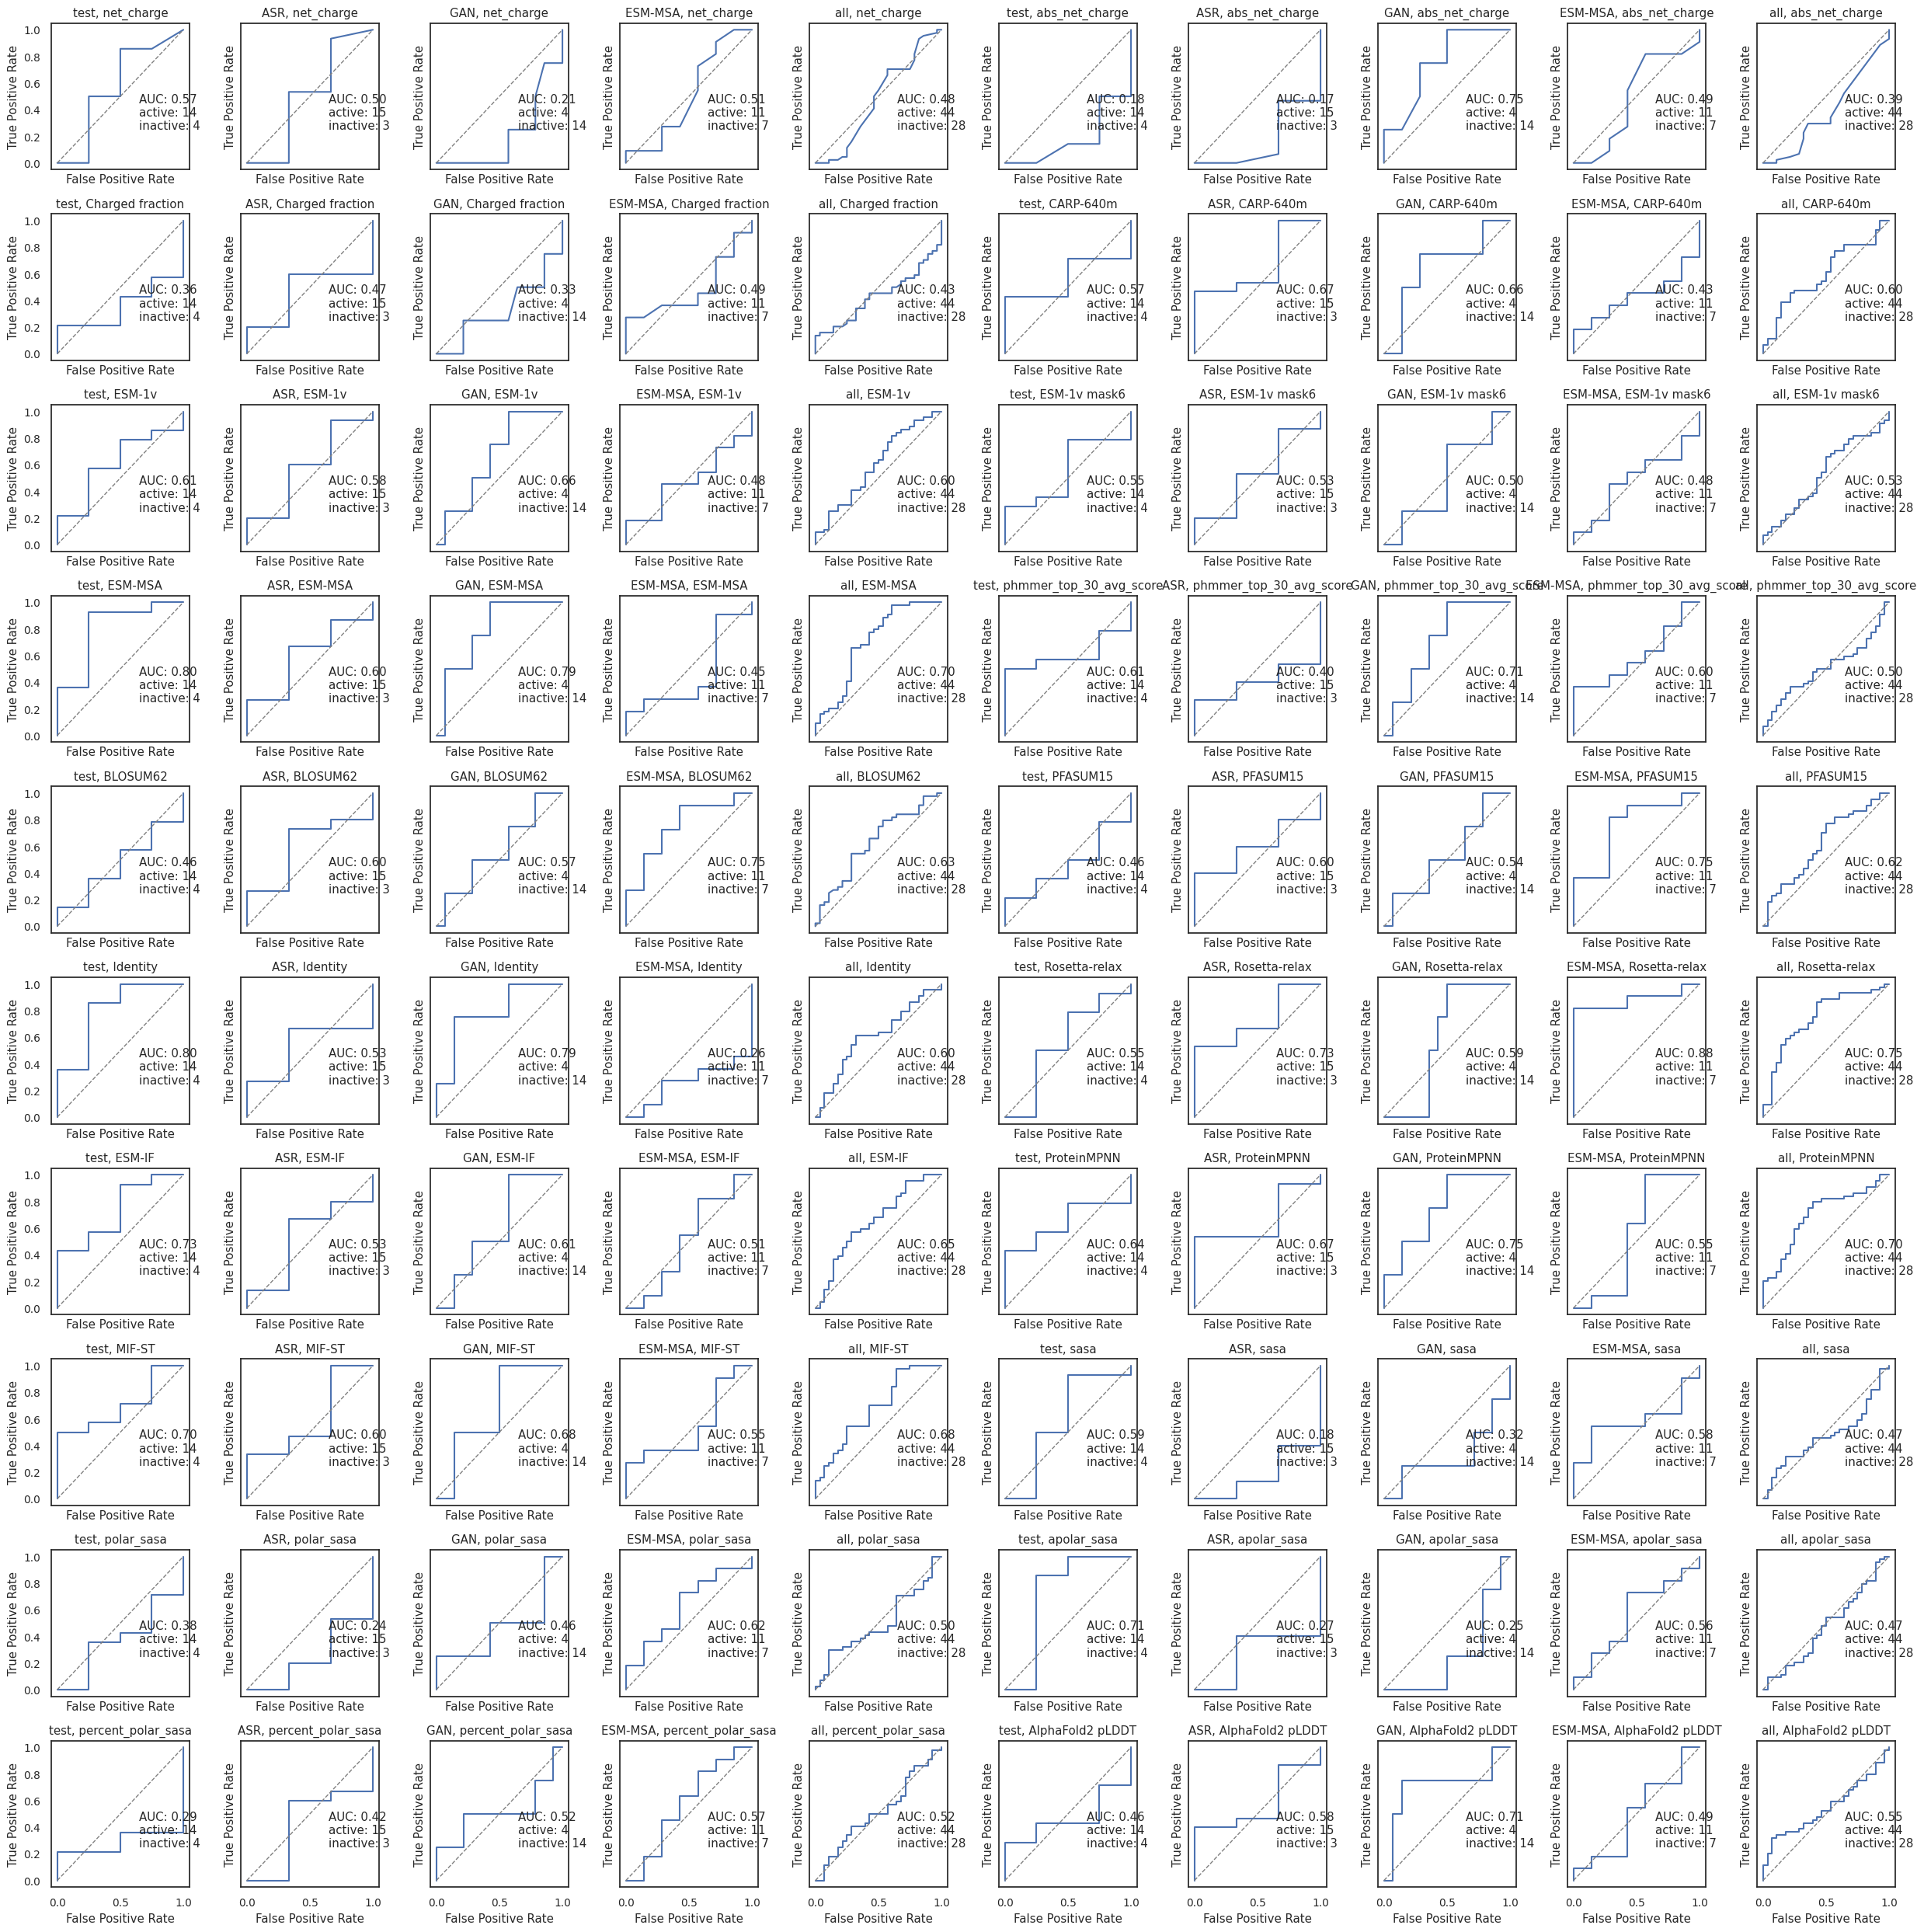

In [29]:
fig, axes = plt.subplots(math.ceil(5*(len(ALL_METRICS))/10), 10, sharex=True, sharey='row', figsize=(25,25))
axes = axes.flat
family = "MDH"
aucs_dict = dict() # dict of dicts to store AUCs
ax_i = -1
for metric in ALL_METRICS:

    for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
        
        df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'].isin(model)) & 
        (experimentally_tested_metrics['Family'] == family)
        ]
        
        if model == ("test", "ASR", "GAN", "ESM-MSA"):
            model = "all"
        else:
            model = model[0]
        
    
        if model not in aucs_dict:
            aucs_dict[model] = dict()    
        
        ax_i += 1
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[ax_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        aucs_dict[model][metric] = auc_value
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_AUCs_{family}.png", dpi=300)
pd.DataFrame(aucs_dict).to_csv(f"{outdir}/round2_supplemental_AUCs_{family}.tsv", sep="\t")

In [30]:
def precision_curve(x,y, percentile = False, reverse=True):
    """
        x: a list of reals
        y: a list of bools (Positive vs Negative)
        percentile: if True then the first column of output is percentile otherwise it is x

        returns:
            a numpy array with three columns, x (or percentile x), and cumulative positive rate up to x, y (sorted with x).

    """
#    x_precentile = [percentileofscore(x,z) for z in x] #probably not very efficient because it has to sort x each time, later versions of scipy stats can do it in one call.
    arr = np.array([x,y]).T
    arr = arr[arr[:,0].argsort()][::-1]
    arr_len = arr.shape[0]
#     print(f"  0%: {arr[0,0]:0.2f}")
#     print(f" 25%: {arr[math.ceil(arr_len*0.25),0]:0.2f}")
#     print(f" 50%: {arr[math.ceil(arr_len*0.5),0]:0.2f}")
#     print(f" 75%: {arr[math.ceil(arr_len*0.75),0]:0.2f}")
#     print(f"100%: {arr[arr_len-1,0]:0.2f}")
    
    
    cumulative_precision = np.zeros((arr_len))

    positives = 0 
    total = 0
    
    for i in range(arr_len):
        total += 1
        if arr[i, 1]:
            positives += 1
        cumulative_precision[i] = positives/total
        
    if percentile:
        percentile_vals = (np.array(range(arr_len)).T +1) / arr_len
        out = np.stack( (percentile_vals, cumulative_precision, arr[:, 1]) ).T
    else:
        out = np.stack( (arr[:,0], cumulative_precision, arr[:, 1]) ).T

    return out

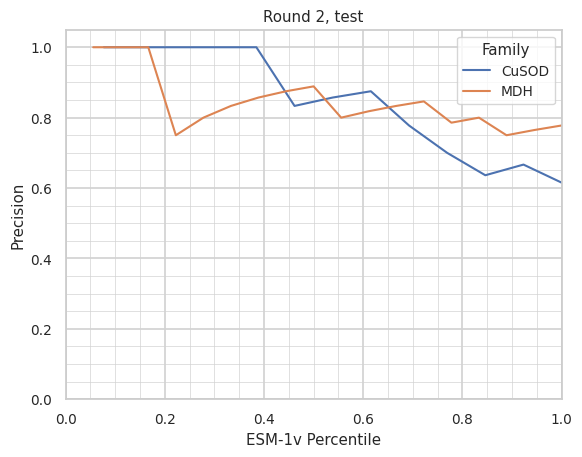

In [31]:
metric = "ESM-1v"
model = "test"
family="CuSOD"

dataframes = list()
for family in ("CuSOD", "MDH"):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] == model) & 
        (experimentally_tested_metrics['Family'] == family)
        ]

    pc = pd.DataFrame(precision_curve(df[metric], df["Activity"], percentile=True),columns=[metric + " Percentile", "Precision", "Active"])
    pc["Family"] = family
    dataframes.append(pc)

pcs = pd.concat(dataframes, ignore_index=True)
sns.set_style("whitegrid") # change theme so we can see the ticks
ax = sns.lineplot(x=metric + " Percentile", y="Precision", data=pcs, hue="Family")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(visible=True, which='minor', color='lightgrey', linewidth=0.5)
ax.grid(visible=True, which='major', color='lightgrey', linewidth=1.25)
ax.set_title("Round 2, " + model )
plt.ylim(0, 1.05)
plt.xlim(0, 1.00)
sns.reset_orig()
plt.savefig(f"{outdir}/round2_supplemental_test_cumulative_precision.png", dpi=300)

In [39]:
pcs

,ESM-1v Percentile,Precision,Active,Family
0,0.076923,1.000000,1.0,CuSOD
1,0.153846,1.000000,1.0,CuSOD
2,0.230769,1.000000,1.0,CuSOD
3,0.307692,1.000000,1.0,CuSOD
4,0.384615,1.000000,1.0,CuSOD
5,0.461538,0.833333,0.0,CuSOD
6,0.538462,0.857143,1.0,CuSOD
7,0.615385,0.875000,1.0,CuSOD
8,0.692308,0.777778,0.0,CuSOD
9,0.769231,0.700000,0.0,CuSOD


In [32]:
fig, axes = plt.subplots(len(ALL_METRICS), 2,sharex=True, sharey=True, figsize=(8,30))
#'GAN-passing': "#2ca02c",'GAN-control': "#2ca02c", 'ESM-MSA-passing': '#d62728', 'ESM-MSA-control'
for family_i, family in enumerate(["CuSOD", "MDH",]):
    metric_i = 0
    #print(experimentally_tested_metrics)
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3') &
    (experimentally_tested_metrics['Family'] == family)
    ]
    for metric in ALL_METRICS:
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, family_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{family}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round3_supplemental_AUCs.png", dpi=300)

In [37]:
from scipy.stats import ranksums
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Model'] != "test" )
#    (experimentally_tested_metrics['Family'] != "MDH" )
]

positives = df[df["Activity"] == 1]
negatives = df[df["Activity"] == 0]

for metric in MAIN_TEXT_METRICS:
    print(metric)
    print(ranksums(positives[metric], negatives[metric]).pvalue)

CARP-640m
0.001118637833103581
ESM-1v
0.0035019411661637774
ESM-MSA
0.07697014493244864
BLOSUM62
0.04392602883697521
Identity
0.20535445382551376
Rosetta-relax
0.0859109084980084
ESM-IF
0.0005724516853524527
ProteinMPNN
2.7572152203393923e-07
MIF-ST
0.0004195163809746706
AlphaFold2 pLDDT
0.00047315468835299303


In [50]:
from scipy.stats import ranksums
for family in ("MDH", "CuSOD"):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] != "pre-test" ) &
    #    (experimentally_tested_metrics['Model'] != "test" )
        (experimentally_tested_metrics['Family'] == family )
    ]

    positives = df[df["Activity"] == 1]
    negatives = df[df["Activity"] == 0]
    print(family)
    for metric in MAIN_TEXT_METRICS:
        print(metric)
        print(ranksums(positives[metric], negatives[metric]).pvalue)
    print(f"family {family} positives: {len(positives)}, negatives: {len(negatives)}")

MDH
CARP-640m
0.1553787141648122
ESM-1v
0.1553787141648122
ESM-MSA
0.00465446975308545
BLOSUM62
0.06712272024339043
Identity
0.1392626338390447
Rosetta-relax
0.00044552108395178226
ESM-IF
0.03355284806859625
ProteinMPNN
0.00465446975308545
MIF-ST
0.011797552210127455
AlphaFold2 pLDDT
0.5177210427207923
family MDH positives: 44, negatives: 28
CuSOD
CARP-640m
0.000828188583203408
ESM-1v
0.0006787935979357299
ESM-MSA
0.721659053749325
BLOSUM62
0.15416600795966967
Identity
0.12155388554976074
Rosetta-relax
0.0002677729931491202
ESM-IF
0.0009596629318491116
ProteinMPNN
0.00011160934285469546
MIF-ST
0.000583631839186707
AlphaFold2 pLDDT
0.000501013320010194
family CuSOD positives: 47, negatives: 20


In [40]:
from scipy.stats import fisher_exact
# selected sequences have a higher success rate than control sequences

#[[active passing, inactive passing],[active control, inactive control]]
fisher_exact([[53,19],[30,42]])

(3.905263157894737, 0.0001829548852611704)

In [49]:
#[[active passing, inactive passing],[active control, inactive control]]
#fisher_exact([[78,37],[13,11]])

fisher_exact([[20,31],[10,11]])

(0.7096774193548387, 0.6019513599183746)